In [35]:
import sys
import os
import pandas as pd
import re

from my_package.data.select_dataset import get_dataframe_from_database
from my_package.data.load_database import load_database

# 경로 설정: 스크립트 경로에서 상위 디렉토리로 이동한 후 src 경로 추가
health_data_path = os.path.abspath(os.path.join('..', '..','src'))

paths = [health_data_path]

def add_paths(paths):
    """
    지정된 경로들이 sys.path에 없으면 추가하는 함수.
    
    Parameters:
    - paths (list): 추가하려는 경로들의 리스트.
    """
    for path in paths:
        if path not in sys.path:
            sys.path.append(path)
            print(f"Path added: {path}")
        else:
            print(f"Path already exists: {path}")
            
add_paths(paths)

Path already exists: C:\Users\pc021\Desktop\dx_project\techross\health_data\src


In [36]:
# 옵션 설정

pd.set_option('display.max_rows',600)

In [41]:
def preprocess_log_file(file_path):
    """
    로그 파일을 읽고 전처리하여 데이터프레임으로 반환하는 함수입니다.

    Parameters:
        file_path (str): 전처리할 로그 파일의 경로
    
    Returns:
        pd.DataFrame: 정리된 로그 데이터
    """
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            # 공백과 줄바꿈 제거
            line = line.strip()
            if line:
                # 처리 시간과 로그 내용 분리
                timestamp, log_content = line.split(" - INFO - ", 1)
              
                # 로그 내용 파싱
                parsed_content = dict(item.split('=') for item in log_content.split(' | '))
                
                # 처리 시간을 새로운 컬럼으로 추가
                parsed_content['PREOCESSING_TIME'] = timestamp
                    
                # 데이터 리스트에 추가
                data.append(parsed_content)
                
    # 데이터 리스트를 데이터프레임으로 변환
    df = pd.DataFrame(data)
    
    return df

log_20241112 = preprocess_log_file('log_20241112.log')
log_20241113 = preprocess_log_file('log_20241113.log')
log_20241114 = preprocess_log_file('log_20241114.log')

log = pd.concat([log_20241112,log_20241113,log_20241114])
log = log.reset_index(drop=True)
log['OP_INDEX'] = log['OP_INDEX'].astype('int')

log 분석

오퍼레이션 처리 개수 : 2500

오퍼레이션 처리 실패 개수 : 10만건 이상

오퍼레이션 40개 이하 8만건 이상

C:\Users\pc021\AppData\Local\Temp\ipykernel_16976\4010129357.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_false_data_len['len']  = log_false_data_len['LOG_ENTRY'].apply(lambda x: int(re.search(r'\d+',x).group()))


<AxesSubplot: ylabel='Frequency'>

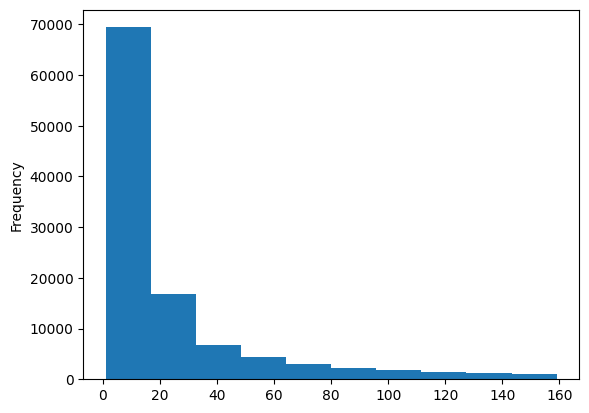

In [68]:
# 처리되지 않은 데이터 추출
log_false = log[log['is_processed']=='False']
log_false_data_len = log_false[log_false['LOG_ENTRY'].str.startswith('데이터 개수')]

# 데이터 개수 추출
log_false_data_len['len']  = log_false_data_len['LOG_ENTRY'].apply(lambda x: int(re.search(r'\d+',x).group()))

# 히스토그램 시각화
log_false_data_len['len'].plot(kind='hist')

In [44]:
# load_database(log,'tc_ai_log') 

DataFrame has been successfully loaded into tc_ai_log table in signlab database.


In [30]:
log[(log['SHIP_ID']=='T130411-00501') & (log['OP_INDEX']==210) & (log['SECTION']=='0')]

,SHIP_ID,OP_INDEX,SECTION,START_TIME,LOG_ENTRY,TYPE,is_processed,PREOCESSING_TIME
777,T130411-00501,210,0,2022-09-11 23:52:40,모델 및 통계 패키지 통해 결과를 도출했습니다,ALL,True,2024-11-12 09:10:04
778,T130411-00501,210,0,2022-09-11 23:52:40,`distance` must be greater or equal to 1,MAIN,FALSE,2024-11-12 09:10:05


In [35]:
# 예시 데이터프레임 (이미 데이터프레임으로 로드되어 있다고 가정)# data = pd.read_csv('your_data.csv')

# 데이터프레임을 OP_INDEX 기준으로 정렬 (SHIP_ID가 같을 때 순차적으로 정렬되어 있다고 가정)
data = log.sort_values(['SHIP_ID', 'OP_INDEX']).reset_index(drop=True)

# 이전 OP_INDEX 값과 비교하여 순차적 증가가 아니면 True로 표시
data['OP_INDEX_SHIFT'] = data.groupby('SHIP_ID')['OP_INDEX'].shift(1)
data['IS_SEQUENTIAL'] = (data['OP_INDEX'] == data['OP_INDEX_SHIFT'] + 1) | data['OP_INDEX_SHIFT'].isna()

# 순차적이지 않은 부분만 필터링
anomalies_df = data[~data['IS_SEQUENTIAL']]

# 결과 확인
if anomalies_df.empty:
    print("모든 SHIP_ID에서 OP_INDEX가 순차적으로 증가합니다.")
else:
    print("순차적으로 증가하지 않는 OP_INDEX가 있는 행:")
    print(anomalies_df[['SHIP_ID', 'OP_INDEX', 'OP_INDEX_SHIFT']])

순차적으로 증가하지 않는 OP_INDEX가 있는 행:
             SHIP_ID  OP_INDEX  OP_INDEX_SHIFT
108    T121129-47401        74            72.0
133    T121129-47401       100            98.0
249    T121129-47401       217           215.0
303    T121129-47401       272           270.0
342    T121129-47401       312           310.0
...              ...       ...             ...
77806   T20210910001        21            18.0
77901   T20210910001       117           115.0
77907   T20210910001       124           122.0
77909   T20210910001       128           125.0
77911   T20210910001       131           129.0

[5382 rows x 3 columns]
